In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class Node:
    def __init__(self, nameID, frame, parent = None, meanIntensity = None):
        self.nameID = nameID
        self.frame = frame
        self.parent = parent
        self.children = []
        self.meanIntensity = meanIntensity
        
    def setParent(self, parent):
        self.parent = parent
    def addChild(self, child):
        self.children.append(child)
    def print(self):
        frameNum = self.frame.astype(str)
        print("Name:", self.nameID," Frame:",frameNum ,"Parent:" ,self.parent , " Children:" , self.children)
        for x in self.children:
            x.print()
    def printIntensity(self, ax, colorPlot = 'black'):
        frameNum = self.frame.astype(str)
        #print("Name:", self.nameID," Frame:",frameNum, "Intensity:", self.meanIntensity)
        ax.plot(self.frame, float(self.meanIntensity))
        """ax.plot(self.frame, float(self.meanIntensity), '.',color=colorPlot)
        ax.plot(self.frame, float(self.meanIntensity), '_',color=colorPlot)"""
        list =['g','r','c','m','y','k',]
        #randomly select a color from the list 
        
        for x in self.children:
            if(len(self.children) >= 2 ):
                colorPlot = list[np.random.randint(0, len(list))]  
                list.remove(colorPlot)            
            x.printIntensity(ax, colorPlot = colorPlot)
            
    #adding data into spreadsheet for analysis
    def spreadsheet(self,dataframe, Column, firstFrame, Split=False):
        #check if this is first column, if not add all the infromation of previous column to the current column
        if(Split == True):
            dataframe.loc[0:(self.frame-firstFrame), Column] = dataframe.loc[0:(self.frame-firstFrame), Column-1]
            
        #append the value to appropriate column based on time frame
        #curr frame - first frame = column number to normalize the data
        dataframe.loc[(self.frame-firstFrame), Column] = float(self.meanIntensity)
          
        for x in self.children:
            Split=False
            if(len(self.children) >= 2 ):           
                Column = Column + 1
                Split=True
            x.spreadsheet(dataframe, Column, firstFrame, Split)
            
    def solePrint(self):
        frameNum = self.frame.astype(str)
        print("Name:", self.nameID," Frame:",frameNum ,"Parent:" ,self.parent , " Children:" , len(self.children))

def locateHead(df):
    return df['FRAME'].unique()[0]

def plotTrack(track, dataframe, filename):
    #read in data from csv file
    df = pd.read_csv((filename+'/'+filename+'TrackTables.csv'))
    #Clean up data by removing the first three rows
    df = df.iloc[3:]

    #grab everything with track id of track
    df0 = df.loc[df['TRACK_ID'] == track].copy()
    #change frame to int
    df0['FRAME'] = df0['FRAME'].astype(int)
    #sort by frame
    df0 = df0.sort_values(by=['FRAME']).reset_index(drop=True)

    #import the edge files
    df_edges = pd.read_csv((filename+'/'+filename+'Edges.csv'))
    df_edges = df_edges.iloc[3:].reset_index(drop=True)
    #convert trackid to int first
    df_edges['TRACK_ID'] = df_edges['TRACK_ID'].astype(int)
    #filter out track id of not 0
    df_edges = df_edges.loc[df_edges['TRACK_ID']==int(track)].reset_index(drop = True)
    #find out if a value in source column is repeated
    df_edges['SPOT_SOURCE_ID'].value_counts()

    my_dict = {}
    for x in range(0, len(df0)):
        node = Node(df0['LABEL'][x], df0['FRAME'][x], parent = None, meanIntensity=df0['MEAN_INTENSITY_CH1'][x])
        my_dict[df0['LABEL'][x]] = node

    for x in range(0, len(df_edges)):
        source = "ID"+str(df_edges['SPOT_SOURCE_ID'][x])
        target = "ID"+str(df_edges['SPOT_TARGET_ID'][x])
        my_dict[target].setParent(my_dict[source])
        my_dict[source].addChild(my_dict[target])
        

    # = ID2764
    #find node with nameID ID2764

    root = my_dict[str(df0.loc[df0['FRAME'] == locateHead(df0)]['LABEL'][0])]
    root.spreadsheet(dataframe, 1, root.frame)
    #root.printIntensity(ax)

In [75]:
def plottingFile(filename, ax):
    dataframe = pd.DataFrame()
    dataframe.insert(0, 'Time',0)
    plotTrack("1", dataframe, filename)


    #fill the time column from 0 to len of dataframe
    for i in range(0,len(dataframe)):
        dataframe.iloc[i,0] = i
        
    dataframe.to_csv((filename+'TimedExcel.csv'), index=False)
    #plot a graph using each the first column as x axis and the rest as y axis 

    for i in range(1,len(dataframe.columns)):
        data = pd.Series(dataframe.iloc[:,i])
        smoothed = data.rolling(window=5).mean()    
        ax.plot(dataframe.iloc[:,0], dataframe.iloc[:,i], label = 'ID'+str(i-1))
        ax.plot(dataframe.iloc[:,0], smoothed, label = 'smoothed'+str(i-1))
    ax.legend()


IndexError: index 0 is out of bounds for axis 0 with size 0

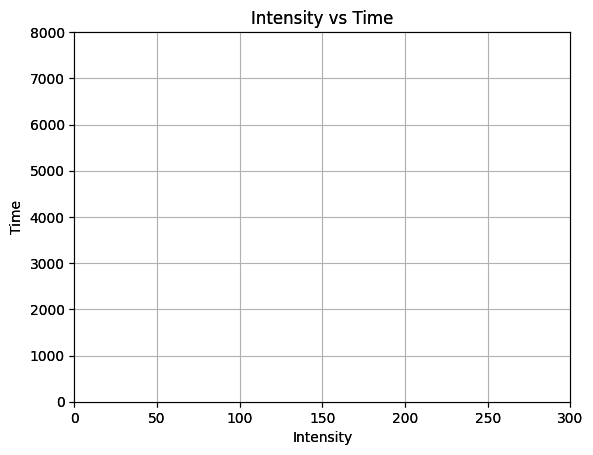

In [76]:
#generalized function to be able to call all the files and showcase their graphs for best comparison
list = ['XY2', 'XY3', 'XY4','XY5']
figure = plt.figure()

for file in list:
    ax = figure.add_subplot()
    ax.set_title('Intensity vs Time')
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Time')
    ax.set_xlim(0,300)
    ax.set_ylim(0,8000)
    ax.grid(True)
    ax.set_axisbelow(True)
    filename = file
    
    plottingFile(filename, ax)